
En este Notebook se discuten los posibles 'tipos' de ajuste a la función de f-scan para hallar el coeficiente de absorción de dos fotones (TPA),

$$T(f,β;\{L, P_{av}, T_{p}, w_{l}, D, ds, C_f, \alpha, R\})=1-\frac{1}{2\sqrt{2}} \frac{\beta (1-R) I_0(f)L_{eff}}{1+\left(\frac{d_s-f}{z_0(f)}\right)^{2}} \hspace{2 mm} (1)$$

El notebook cuenta con dos partes:

parte a): permite estudiar el calculo de $\beta$ mediante el método directo usando la tecnica $\chi^{2}$. Además se puede explorar el efecto de poseer incertidumbre en los diferentes parametros al momento de realizar el ajuste.

parte b): permite estudiar el calculo de $\beta$ mediante el protocolo definido. Se implemente diferentes metricas con las función 'protocolo'.

In [2]:
# Libraries #
import numpy as np
import locale
_locale_radix = locale.localeconv()['decimal_point']
import pylab as plt
import sys
from scipy import stats
from scipy.optimize import fmin
import pandas as pd
import os
from scipy.optimize import curve_fit
from google.colab import drive


drive.mount('/content/drive')

path='/content/drive/MyDrive/Projects/TPA' # Cambiar en caso de tener el proyec
#to en otra carpeta

os.chdir(path)

Mounted at /content/drive





# Funciones utilizadas a lo largo del articulo.



In [1]:
def delta(m,n):
  '''
  Delta de Kronecker.
  '''
  if m==n: return 1
  else: return 0

def p(m):
    '''
    Productoria de la expresión (1)
    '''
    pro=1
    for n in range(0,m+1):
        pro=pro*(2*(m-n)+delta(m,n))/(2*(m-n)+1)
    return pro


# Función ajustar
def fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    B = beta*(1.0 - R)*I0*Leff
    # Transmitance
    T=1-1/(2*np.sqrt(2))*beta*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2)
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return T



# Cambio de corriente a distancia focal
def focalcurr(ecu,corr):
  '''
  Cambio de corriente [mA] a distancia focal [m]

  Parametros
  ----------
  ecu: String
      Parametro tipo cadena 'opt1' o 'opt2' dependiendo
      del tipo de ecuación de ajuste.
  corr: Arreglo
      Arreglo con distancias focales utilizadas.

  La función devuelve la distancia focal
  '''
  if(ecu=='opt1'):
      focal = 1/(0.045*corr + 1.522)
  elif(ecu=='opt2'):
      focal = (1/(5.9e-5*corr + 4.9e-3) + 1.7)*1e-3
  return focal

def ruido(señal,desv): 
    '''
    Función para añadir ruido Gaussiano dada una desviación estandar

    Parametros
    ----------
    señal: Arreglo
      Arreglo con la señal a la que se le va añadir el ruido
    desv: float
      Desviación estandar
    '''
   
    señal_ruido=np.zeros(len(señal))
    señal_ruido=[ np.random.normal(señal[i], desv) for i in range(0,len(señal))]
    return np.array(señal_ruido)

# Archivo con los datos que se asumiran como reales.
df = pd.read_csv('Parametros_fscan.txt', delimiter = "\t",index_col=0)

NameError: ignored

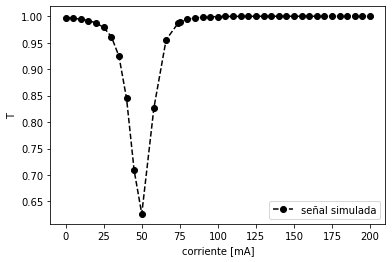

In [ ]:
# Señal con ruido.

# Corriente con menos puntos cerca de la caida.
corriente=[i for i in range(0,50,5)]
for i in range(50,75,8):
  corriente.append(i)
for i in range(75,203,5):
  corriente.append(i)

corriente=np.array(corriente)
######################## PARAMETROS QUE SE ASUMEN COMO LOS REALES
focal=focalcurr('opt2',corriente) #focal distance [m]
beta = 500e-11 # TPA seed in (m/W )
L= 0.70e-3 # thickness in (m).
Pavg = 95e-3# Average power in (W)
Tp = 2e-9 # pulse width FWHM in (s)
wl = 1063.5e-9 #central wavelength in (m)
D = 1.5e-3 # beam diameter in (m)
ds = 130e-3# Distance EFTL-sample (m)
Cf = 1.1 # beam correction coeff
alfa = 975 # linear absorption in (1/m) 
R =0.33 # reflection percentage 
freq = 11e3 #Frecuencia en HZ


T=fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)  #Señal simulada

#Td= np.gradient(T)

#Pavg=Pavg+0.05*Pavg
#L=L+0.05*L
#ds=ds+0.05*ds


def fscanTH(focal,beta):
  '''
  Función utilizada para hallar beta
  '''

  Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
  w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
  z0 = np.pi*w0**2/wl # Rayleigh range
  w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
  I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
  B = beta*(1.0 - R)*I0*Leff
  # Transmitance
  T=1-1/(2*np.sqrt(2))*beta*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2)
  #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
      ##  for i in range(len(B))]
  return (T)

plt.plot(corriente,T,'--ko',label='señal simulada')
#plt.plot(corriente,Td,'--ro',label='derivada')
plt.ylabel('T')
plt.xlabel('corriente [mA]')
plt.legend()


# Comprobación del método directo con ajuste $\chi^{2}$

O

Text(0, 0.5, 'Counts')

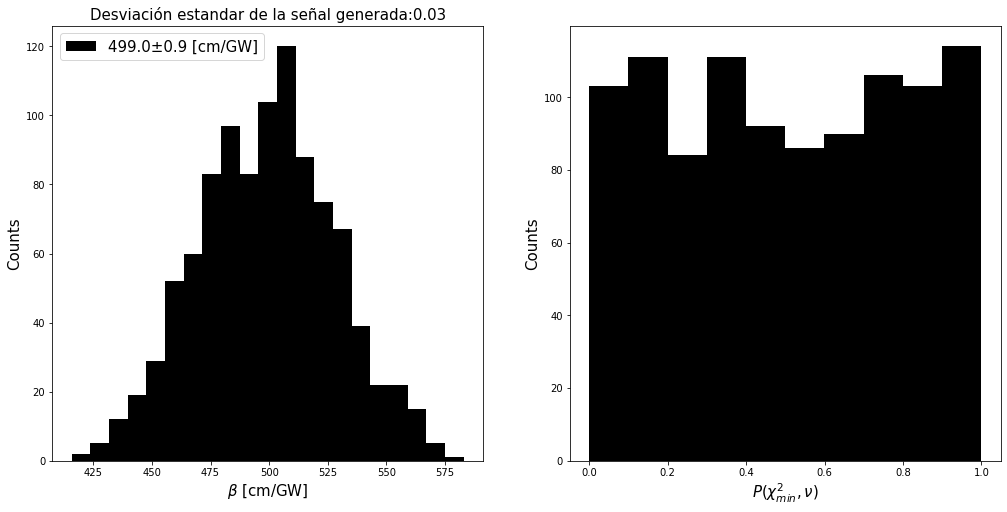

In [ ]:
cantidad_ruido=0.03 # Desviación estandar del ruido.
betas=[]
prob=[]
for i in range(1000):


  señal_ruido=ruido(T,cantidad_ruido)  # Señal con ruido
  b2, cov = curve_fit(fscanTH,focal,señal_ruido ,p0=[beta]) #Minimos cuadrados.
  ajuste_ruido=fscanTH(focal,b2[0]) 
  betas.append(b2[0]*1e11)
  nu=len(T)-1 # Grados de libertad
  chi_min=sum((ajuste_ruido[i]-señal_ruido[i])**2/cantidad_ruido**2 for i in range(len(T)))
  Prob= 1 - stats.chi2.cdf(chi_min, nu) ## P(\chi^2_min,\nu)
  prob.append(Prob)
  

f=plt.figure(figsize=(17,8))

plt.subplot(1,2,1)
error=str(round(np.std(betas,ddof=1)/np.sqrt(len(betas)),1))
plt.hist(betas,bins='fd',color='black',label=str(round(np.mean(betas),1))+'±'+error+' [cm/GW]')
plt.xlabel(r'$\beta$ [cm/GW]',fontsize=15)
plt.ylabel('Counts',fontsize=15)
plt.title('Desviación estandar de la señal generada:'+str(cantidad_ruido),fontsize=15)
plt.legend(fontsize=15)
# 


plt.subplot(1,2,2)
plt.hist(prob,bins='fd',color='black')
plt.xlabel(r'$P(\chi^{2}_{min},\nu)$',fontsize=15)
plt.ylabel('Counts',fontsize=15)






# Parte b)

In [ ]:
# -*- coding: utf-8 -*-
#Función de Ajuste 
def protocolo(T_ruido,focal,ruido,metric): 
  '''
  Implementación de protocolo de ajuste para el calculo de beta
  usando como metrica de ajuste el $\chi$²

  Parametros
  ----------
  T_ruido: Arreglo
      Arreglo con Datos ajustar.
  focal: Arreglo
      Arreglo con distancias focales utilizadas.
  ruido: Número
      Ruido que se le ha añadido a la señal teorica.

  La función devuelve el mejor valor de TPA y su error estandar
  '''
  # Contedra valores de TPA
  TPA=[]
  datos = T_ruido
  Best=[]
  ECMs = [] # creates metric list
  N = int(df.loc['N']['Valor']) #number of terms in the sum of the theoretical formula
  NN =int(df.loc['NN']['Valor']) # sample size
  beta0 = float(df.loc['beta0']['Valor']) # TPA seed in (m/W)

  nu=len(datos)-1 #Degrees of freedom

  L_c = float(df.loc['L_c']['Valor'])*float(df.loc['L_c']['Valor2']) # thickness in (m).
  L_e = float(df.loc['L_e']['Valor'])*float(df.loc['L_e']['Valor2']) # thickness error

  Pavg_c = float(df.loc['Pavg_c']['Valor'])*float(df.loc['Pavg_c']['Valor2']) # Average power in (W)
  Pavg_e = float(df.loc['Pavg_e']['Valor'])*float(df.loc['Pavg_e']['Valor2']) # Average power error

  Tp_c = float(df.loc['Tp_c']['Valor'])*float(df.loc['Tp_c']['Valor2']) # pulse width FWHM in (s)
  Tp_e = float(df.loc['Tp_e']['Valor'])*float(df.loc['Tp_e']['Valor2']) # pulse width error

  wl_c = float(df.loc['wl_c']['Valor'])*float(df.loc['wl_c']['Valor2']) #central wavelength in (m)
  wl_e = float(df.loc['wl_e']['Valor'])*float(df.loc['wl_e']['Valor2']) # central wavelength error

  D_c = float(df.loc['D_c']['Valor'])*float(df.loc['D_c']['Valor2']) # beam diameter in (m)
  D_e = float(df.loc['D_e']['Valor'])*float(df.loc['D_e']['Valor2']) # beam diameter error
  
  ds_c = float(df.loc['ds_c']['Valor'])*float(df.loc['ds_c']['Valor2']) # Distance EFTL-sample (m)
  ds_e = float(df.loc['ds_e']['Valor'])*float(df.loc['ds_e']['Valor2']) # distance EFTL-sample error

  Cf_c = float(df.loc['Cf_c']['Valor']) # beam correction coeff
  Cf_e = float(df.loc['Cf_e']['Valor'])

  alfa_c = float(df.loc['alfa_c']['Valor']) # linear absorption in (1/m) 
  alfa_e = float(df.loc['alfa_e']['Valor'])

  R_c = float(df.loc['R_c']['Valor']) # reflection percentage 
  R_e = float(df.loc['R_e']['Valor'])

  freq_c = float(df.loc['freq_c']['Valor'])*float(df.loc['freq_c']['Valor2']) # Repetition rate in (Hz)
  freq_e = float(df.loc['freq_e']['Valor'])*float(df.loc['freq_c']['Valor2']) # Repetition rate in (Hz)
     
  for ii in range(NN):
      
      er=0.01
      # Randomly chosen parameters, normal distribution
      L_f = np.random.normal(L_c,L_c*er,1) # # thickness in (m).
      Pavg_f = np.random.normal(Pavg_c,Pavg_c*er,1) # Average power in (W)
      Tp_f = abs(np.random.normal(Tp_c,Tp_c*er,1)) # Pulse width FWHM in (s). sech
      wl_f = np.random.normal(wl_c,wl_c*er,1) #central wavelength in (m)
      D_f = np.random.normal(D_c,D_c*er,1) # beam diameter in (m)
      ds_f = np.random.normal(ds_c,ds_c*er,1) # EFTL-sample distance (m)
      Cf_f = np.random.normal(Cf_c,Cf_c*er,1) # Beam correction factor
      alfa_f =  abs(np.random.normal(alfa_c,alfa_c*er,1)) #linear absorption (1/m)
      R_f = np.random.normal(R_c,R_c*er,1) # Reflectance
      freq_f = np.random.normal(freq_c,freq_c*er,1) # Reflectance
      ########################
      # Función ajustar
      def fscanTH(focal,beta):

        Leff = (1. - np.exp(-alfa*L_f))/alfa_f # Effective thickness
        w0 = 2.0*wl_f*focal*Cf_f/(np.pi*D_f) # beam waist
        z0 = np.pi*w0**2/wl_f # Rayleigh range
        w = w0*np.sqrt(1 + ((ds_f - focal)/z0)**2) # Beam radius
        I0 = 4*np.sqrt(np.log(2))*Pavg_f/(Tp_f*freq_f*np.pi**1.5*w**2) # Peak intensity at sample
        B = beta*(1.0 - R)*I0*Leff
        # Transmitance
        T=1-1/(2*np.sqrt(2))*beta*(1-R_f)*I0*Leff/(1+((ds_f-focal)/z0)**2)
        #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
            ##  for i in range(len(B))]
        return T
  # fscan TPA theoretical function with one variable parameter
      def metrica(beta):
            ########################global focal,datos
        T = fscanTH(focal,beta) # Transmitance
        if metric=='chi':
          dist =  sum((T[i]-datos[i])**2/ruido**2  for i in range(len(T))) # values distance
        if metric=='min':
          dmin_E=np.amin(datos)
          dmin_T=np.amin(T)
          dist = (dmin_E-dmin_T)**2 # values distance
        if metric=='max':
          dmax_E=np.amax(datos) # Datos experimentales
          dmax_T=np.amax(T) # Datos teoricos
          dist = (dmax_E-dmax_T)**2 # values distance
        if metric=='chi_min':
          dmin_E=np.amin(datos)
          dmin_T=np.amin(T)
          dist = sum((T[i]-datos[i])**2 for i in range(len(T)))+(dmin_E-dmin_T)**2 # values distance
        return dist

      # Fitting rutine

      betaopt = fmin(metrica, beta0, full_output=False, xtol=1e-8, disp=False)
      ECM=metrica(betaopt[0])# Metric \chi_{min}^2
      Prob= 1 - stats.chi2.cdf(ECM, nu) ## P(\chi^2_min,\nu)
  
      ########################
      ECMs = np.append(ECMs,ECM) # Metric values vector
      
      # According to Ifan Hughes when this condition is satisfied 
      # the null hypothesis is generally not rejected

      if metric=='chi':
        if (nu-2*np.sqrt(2*nu))<=ECM<=(nu+2*np.sqrt(2*nu)): 
          
            miro = np.concatenate((np.array([ECM]),betaopt,L_f,Pavg_f,Tp_f,wl_f,
                                  D_f,ds_f,Cf_f,alfa_f,R_f))
          
            Best = np.append(Best,miro)

      # Por el momento para las otras metricas no se exige condición
      #alguna para aceptación.

      if metric=='chi_min':
        

        miro = np.concatenate((np.array([ECM]),betaopt,L_f,Pavg_f,Tp_f,wl_f,
                                  D_f,ds_f,Cf_f,alfa_f,R_f))
        Best = np.append(Best,miro)
      

      if metric=='min' or metric=='max':

        

        miro = np.concatenate((np.array([ECM]),betaopt,L_f,Pavg_f,Tp_f,wl_f,
                                  D_f,ds_f,Cf_f,alfa_f,R_f))
      
        Best = np.append(Best,miro)

  tamBest = int(len(Best)/11) # size of best-fit values vector
  
  Best = np.reshape(Best,(tamBest,11)) # Matrix where each row contains
  # The parameters of the fit in the following order
  # np.array([ECM]),betaopt,L_f,Pavg_f,Tp_f,wl_f, D_f,ds_f,Cf_f,alfa_f,R_f)
                                 
  ########################
  if len(Best[:,1])!=0:
  # Best values average TPA
      Best_avg = [np.average(Best[:,1])*1e11]# cm/GW
      error= [np.std(Best[:,1]*1e11 )/len(Best[:,1])] # Error estandar.
  else:
    Best_avg=[]
    error=[]
    
  return Best_avg, error

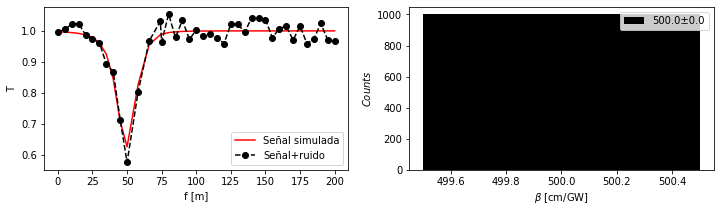

In [ ]:
señal_ruido=ruido(T,cantidad_ruido)
beta_hist=[]
beta_min=[]
number=1000 # Número de ajustes
for i in range(0,number):
  #EJEMPLO
  r1,r2= protocolo(señal_ruido,focal,cantidad_ruido,'max')
  if len(r1)>=1:
    beta_hist.append(r1[0])

f=plt.figure(figsize=(12,3))

plt.subplot(1,2,1)
plt.plot(corriente,T,'r',label='Señal simulada')
plt.plot(corriente,señal_ruido,'--ko',label='Señal+ruido')
plt.ylabel('T')
plt.xlabel('f [m]')
plt.legend()


plt.subplot(1,2,2)
error=str(round(np.std(beta_hist,ddof=1)/np.sqrt(len(beta_hist)),1))
plt.hist(beta_hist,bins='fd',color='black',label=str(round(np.mean(beta_hist),1))+'±'+error)
plt.xlabel(r'$\beta$ [cm/GW]')
plt.ylabel('$Counts$')
plt.legend()